# Compare performance across concentration and representation

Compare classifier metrics across different consensus profile strategies, stratefied by representations types. 

In [1]:
import polars as pl 
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison
import warnings

## Input annotations

In [2]:
endpoint_types = ["toxcast_cellbased", "toxcast_cellfree", "toxcast_cytotox", "axiom"]

pred_df = []
for et in endpoint_types:
    preds = pl.read_parquet(f"../compiled_results/compiled_{et}_metrics.parquet")
    preds = preds.with_columns(
        (pl.col("Metadata_Count_0") + pl.col("Metadata_Count_1")).alias("Total_Compounds"),
        pl.lit(et).alias("Endpoint_type")
    )
    pred_df.append(preds)

pred_df = pl.concat(pred_df, how="vertical")
pred_df = pred_df.with_columns(
    pl.when(pl.col("Endpoint_type") == "axiom").then(pl.lit("axiom_cytotox")).otherwise(pl.col("Endpoint_type")).alias("Endpoint_type")
)

pred_df = pred_df.filter(pl.col("Model_type") == "Actual")

### Compare concentrations

In [4]:
conc_df = pred_df.filter(pl.col("Feat_type") == "cellprofiler")

pred_pandas = conc_df.to_pandas()
pred_pandas['Endpoint_type'] = pd.Categorical(
    pred_pandas['Endpoint_type'], 
    categories=["axiom_cytotox", "toxcast_cytotox", "toxcast_cellbased", "toxcast_cellfree"],
    ordered=True
)

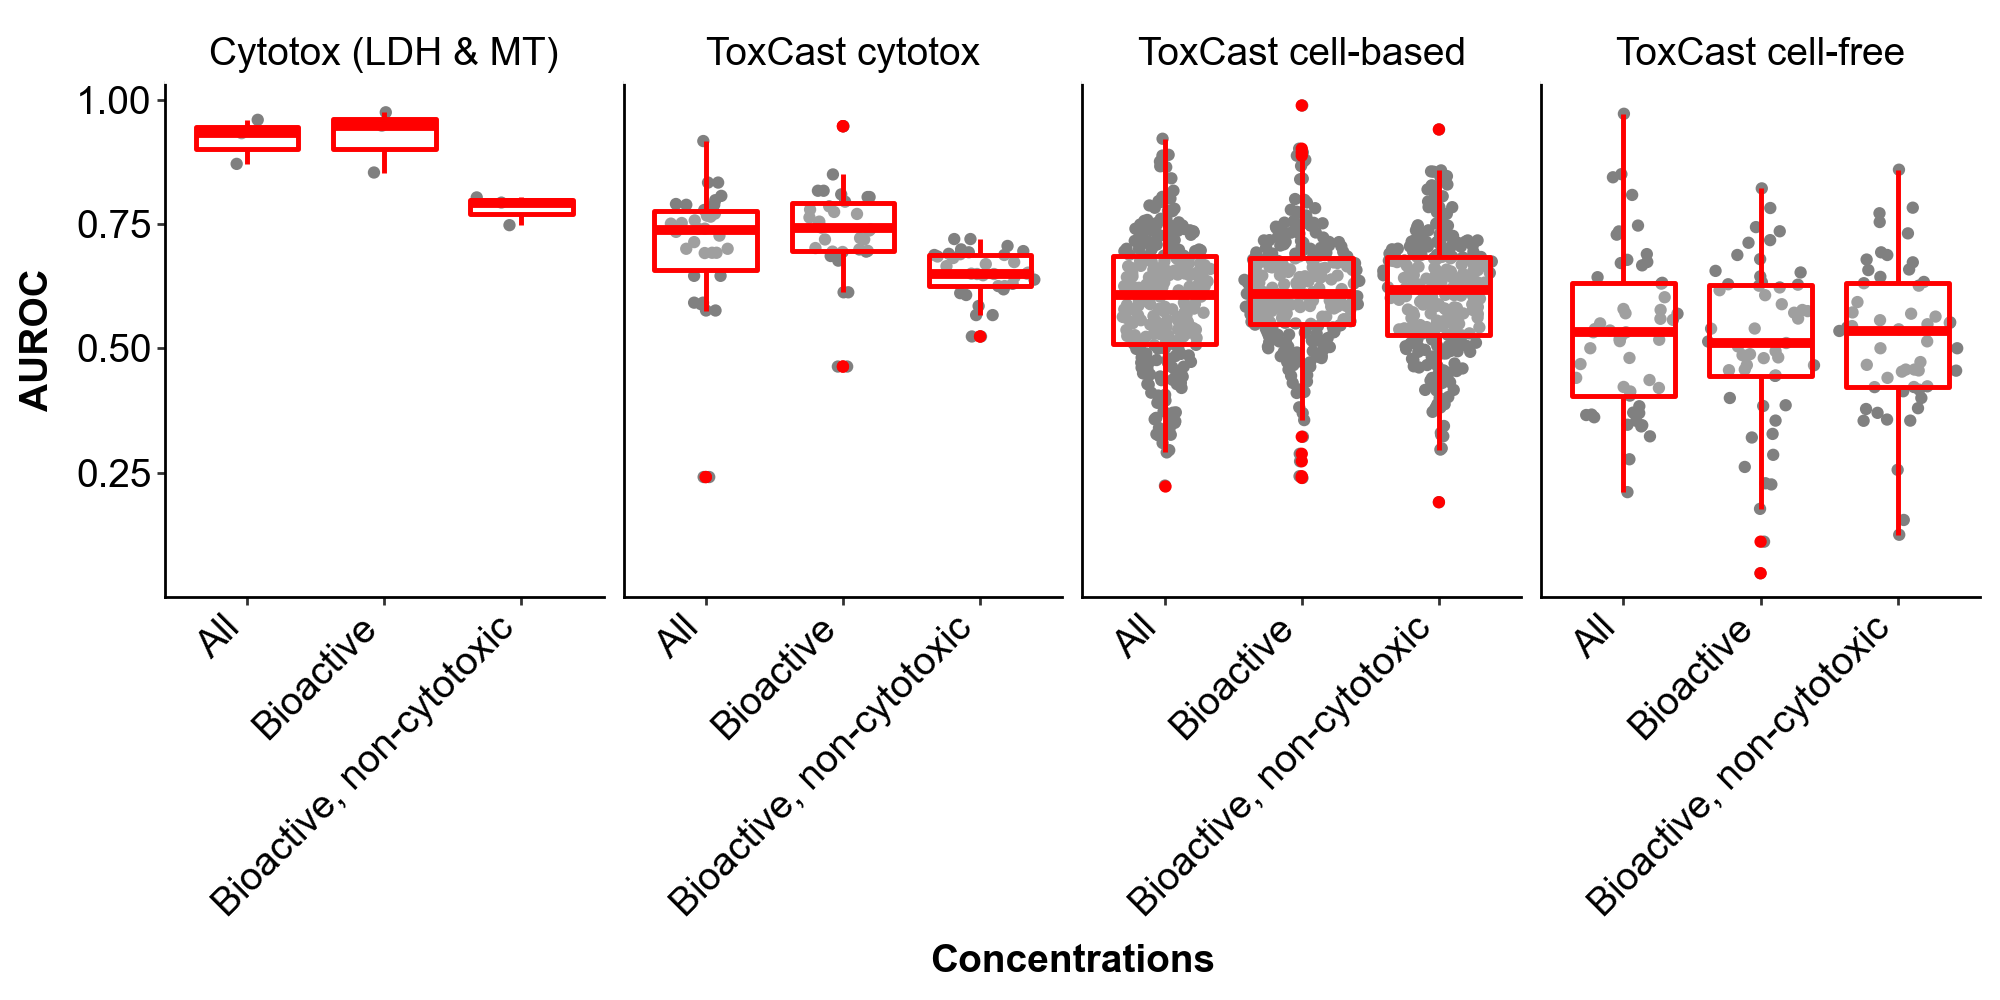

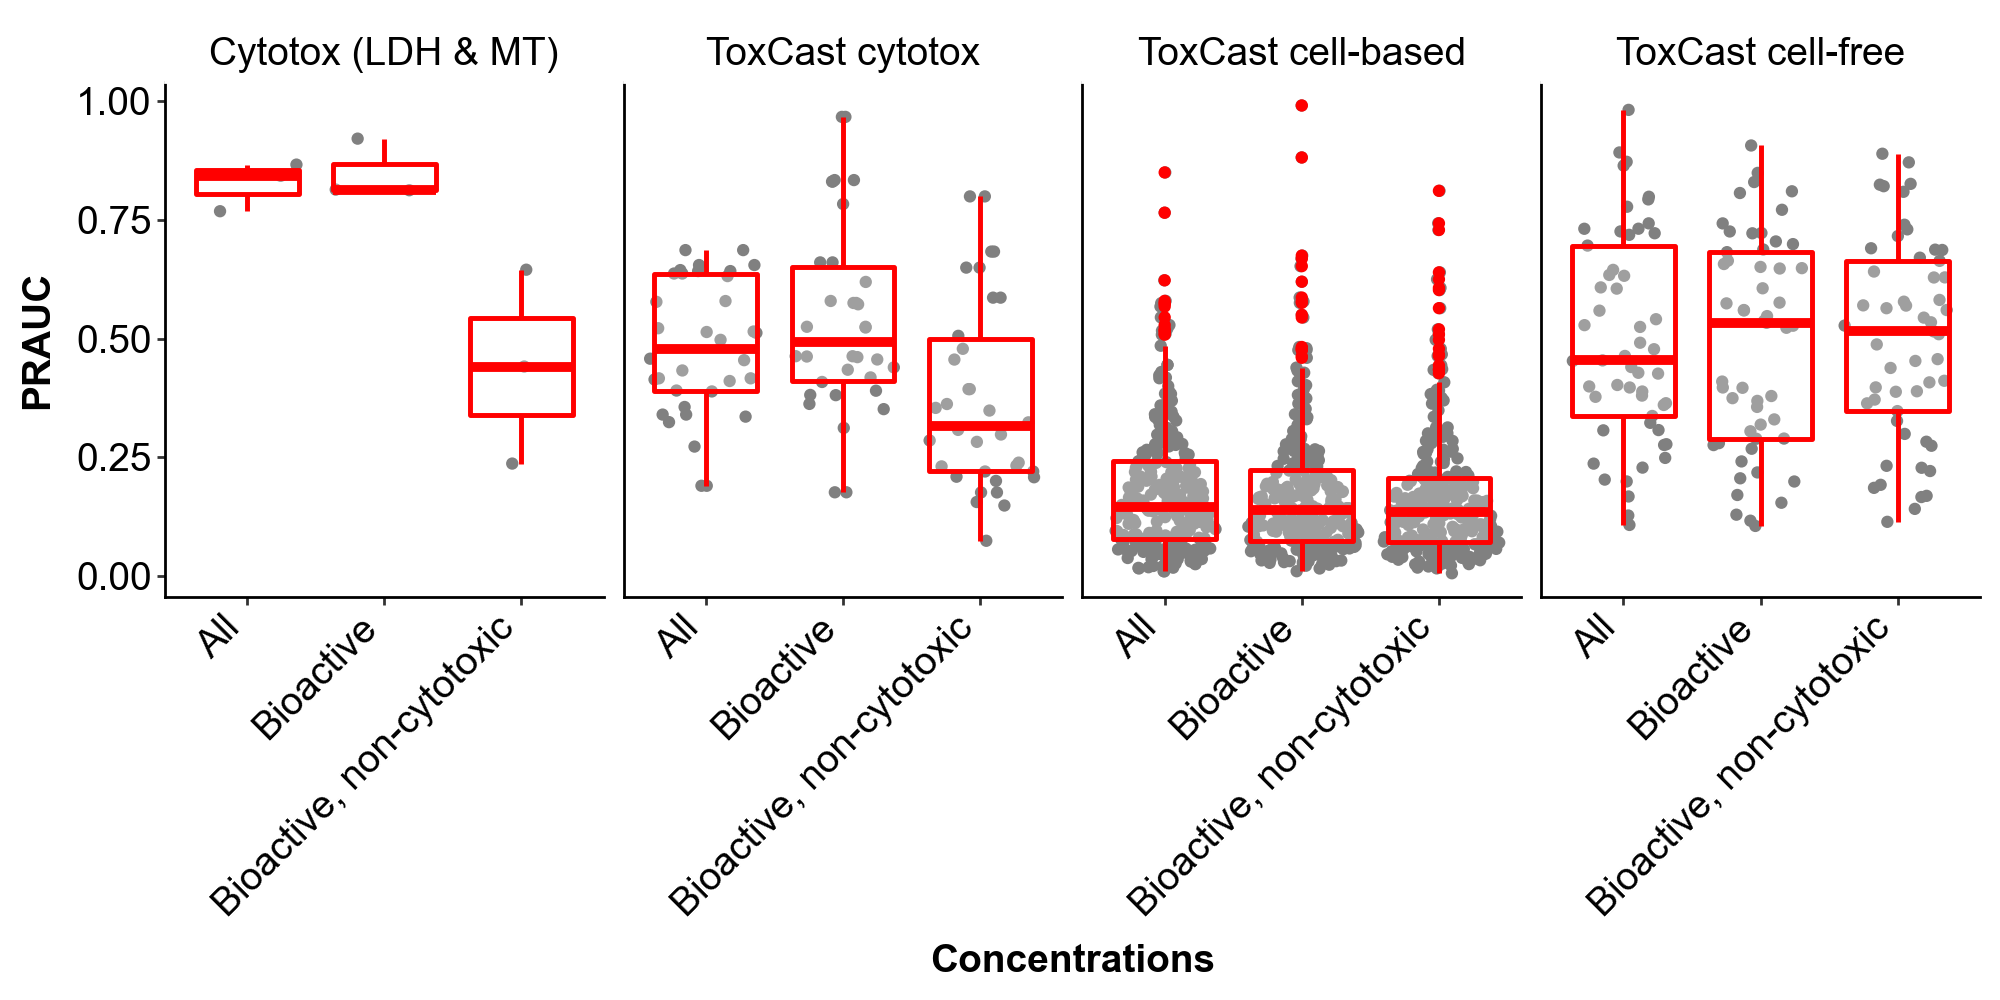

In [6]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_classic, position_dodge, facet_wrap, theme, element_text, scale_x_discrete, element_rect
import plotnine as pn

pn.options.figure_size = (10, 5)

custom_labels = {
    "axiom_cytotox": "Cytotox (LDH & MT)",
    "toxcast_cytotox": "ToxCast cytotox",
    "toxcast_cellbased": "ToxCast cell-based",
    "toxcast_cellfree": "ToxCast cell-free",
}
def label_func(label_dict):
    return lambda x: label_dict.get(x, x)

plot = (
    ggplot(pred_pandas, aes(x='Metadata_AggType', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Endpoint_type", ncol=4, labeller=label_func(custom_labels))
    + labs(x='Concentrations', y='AUROC') 
    + theme_classic()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1, color='black', size=14, family='Arial'),
        axis_text_y=element_text(color='black', size=14, family='Arial'),
        axis_title_x=element_text(size=14, color='black', weight='bold', family='Arial'),
        axis_title_y=element_text(size=14, color='black', weight='bold', family='Arial'),
        strip_text_x=element_text(size=14, color='black', family='Arial'),
        strip_background=element_rect(fill=None, color='white', size=None, linetype=None),
        )
    + scale_x_discrete(labels={
        "all": "All", 
        "allpod": "Bioactive", 
        "allpodcc": "Bioactive, non-cytotoxic"
    })
)
plot.show()

plot = (
    ggplot(pred_pandas, aes(x='Metadata_AggType', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Endpoint_type", ncol=4, labeller=label_func(custom_labels))
    + labs(x='Concentrations', y='PRAUC') 
    + theme_classic()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1, color='black', size=14, family='Arial'),
        axis_text_y=element_text(color='black', size=14, family='Arial'),
        axis_title_x=element_text(size=14, color='black', weight='bold', family='Arial'),
        axis_title_y=element_text(size=14, color='black', weight='bold', family='Arial'),
        strip_text_x=element_text(size=14, color='black', family='Arial'),
        strip_background=element_rect(fill=None, color='white', size=None, linetype=None),
        )
    + scale_x_discrete(labels={
        "all": "All", 
        "allpod": "Bioactive", 
        "allpodcc": "Bioactive, non-cytotoxic"
    })
)
plot.show()

In [14]:
warnings.filterwarnings("ignore")

auroc_results = {}

for endpoint_type, group_data in pred_pandas.groupby("Endpoint_type"):
    print(f"Processing Endpoint_type: {endpoint_type}")
    
    # Fit the mixed-effects model
    model = smf.mixedlm(
        "AUROC ~ Metadata_AggType", 
        group_data, 
        groups=group_data["Metadata_Label"]
    )
    result = model.fit()
    
    # Add fitted values to the subset DataFrame
    group_data["fitted_values"] = result.fittedvalues

    # Perform Tukey's HSD
    mc = MultiComparison(group_data["fitted_values"], group_data["Metadata_AggType"])
    tukey_result = mc.tukeyhsd()
    tukey_pvals = tukey_result.pvalues
    
    # Print results for the current Endpoint_type
    print(tukey_result.summary())
    print("P-values:", tukey_pvals)
    
    # Save results for each Endpoint_type in a dictionary for later reference
    auroc_results[endpoint_type] = {
        "tukey_summary": tukey_result.summary(),
        "tukey_pvalues": tukey_pvals,
        "fitted_model": result
    }

Processing Endpoint_type: axiom_cytotox
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
   all   allpod   0.0042 0.9347 -0.0327  0.0412  False
   all allpodcc  -0.1396 0.0001 -0.1766 -0.1026   True
allpod allpodcc  -0.1439 0.0001 -0.1808 -0.1069   True
------------------------------------------------------
P-values: [9.34661685e-01 6.13982683e-05 5.16627877e-05]
Processing Endpoint_type: toxcast_cytotox
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
   all   allpod   0.0386   0.0  0.0386  0.0386   True
   all allpodcc    -0.05   0.0   -0.05   -0.05   True
allpod allpodcc  -0.0886   0.0 -0.0886 -0.0886   True
-----------------------------------------------------
P-values: [2.43138842e-14 2.43138842e-14 2.43138842e-14]
Processing Endpoint_type: toxcast_cellbas

In [15]:
warnings.filterwarnings("ignore")

auroc_results = {}

for endpoint_type, group_data in pred_pandas.groupby("Endpoint_type"):
    print(f"Processing Endpoint_type: {endpoint_type}")
    
    # Fit the mixed-effects model
    model = smf.mixedlm(
        "PRAUC ~ Metadata_AggType", 
        group_data, 
        groups=group_data["Metadata_Label"]
    )
    result = model.fit()
    
    # Add fitted values to the subset DataFrame
    group_data["fitted_values"] = result.fittedvalues

    # Perform Tukey's HSD
    mc = MultiComparison(group_data["fitted_values"], group_data["Metadata_AggType"])
    tukey_result = mc.tukeyhsd()
    tukey_pvals = tukey_result.pvalues
    
    # Print results for the current Endpoint_type
    print(tukey_result.summary())
    print("P-values:", tukey_pvals)
    
    # Save results for each Endpoint_type in a dictionary for later reference
    auroc_results[endpoint_type] = {
        "tukey_summary": tukey_result.summary(),
        "tukey_pvalues": tukey_pvals,
        "fitted_model": result
    }

Processing Endpoint_type: axiom_cytotox
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
   all   allpod   0.0233 0.7338 -0.0697  0.1164  False
   all allpodcc   -0.385    0.0  -0.478 -0.2919   True
allpod allpodcc  -0.4083    0.0 -0.5013 -0.3152   True
------------------------------------------------------
P-values: [7.33811756e-01 3.62446929e-05 2.57471814e-05]
Processing Endpoint_type: toxcast_cytotox
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
   all   allpod   0.0599 0.0966 -0.0082  0.1279  False
   all allpodcc  -0.1073 0.0009 -0.1754 -0.0392   True
allpod allpodcc  -0.1672    0.0 -0.2352 -0.0991   True
------------------------------------------------------
P-values: [9.66403304e-02 8.62840347e-04 1.96938117e-07]
Processing Endpoint_type: toxcast_

### Compare representations

In [7]:
rep_df = pred_df.filter(pl.col("Metadata_AggType") == "all")

pred_pandas = rep_df.to_pandas()
pred_pandas['Endpoint_type'] = pd.Categorical(
    pred_pandas['Endpoint_type'], 
    categories=["axiom_cytotox", "toxcast_cytotox", "toxcast_cellbased", "toxcast_cellfree"],
    ordered=True
)

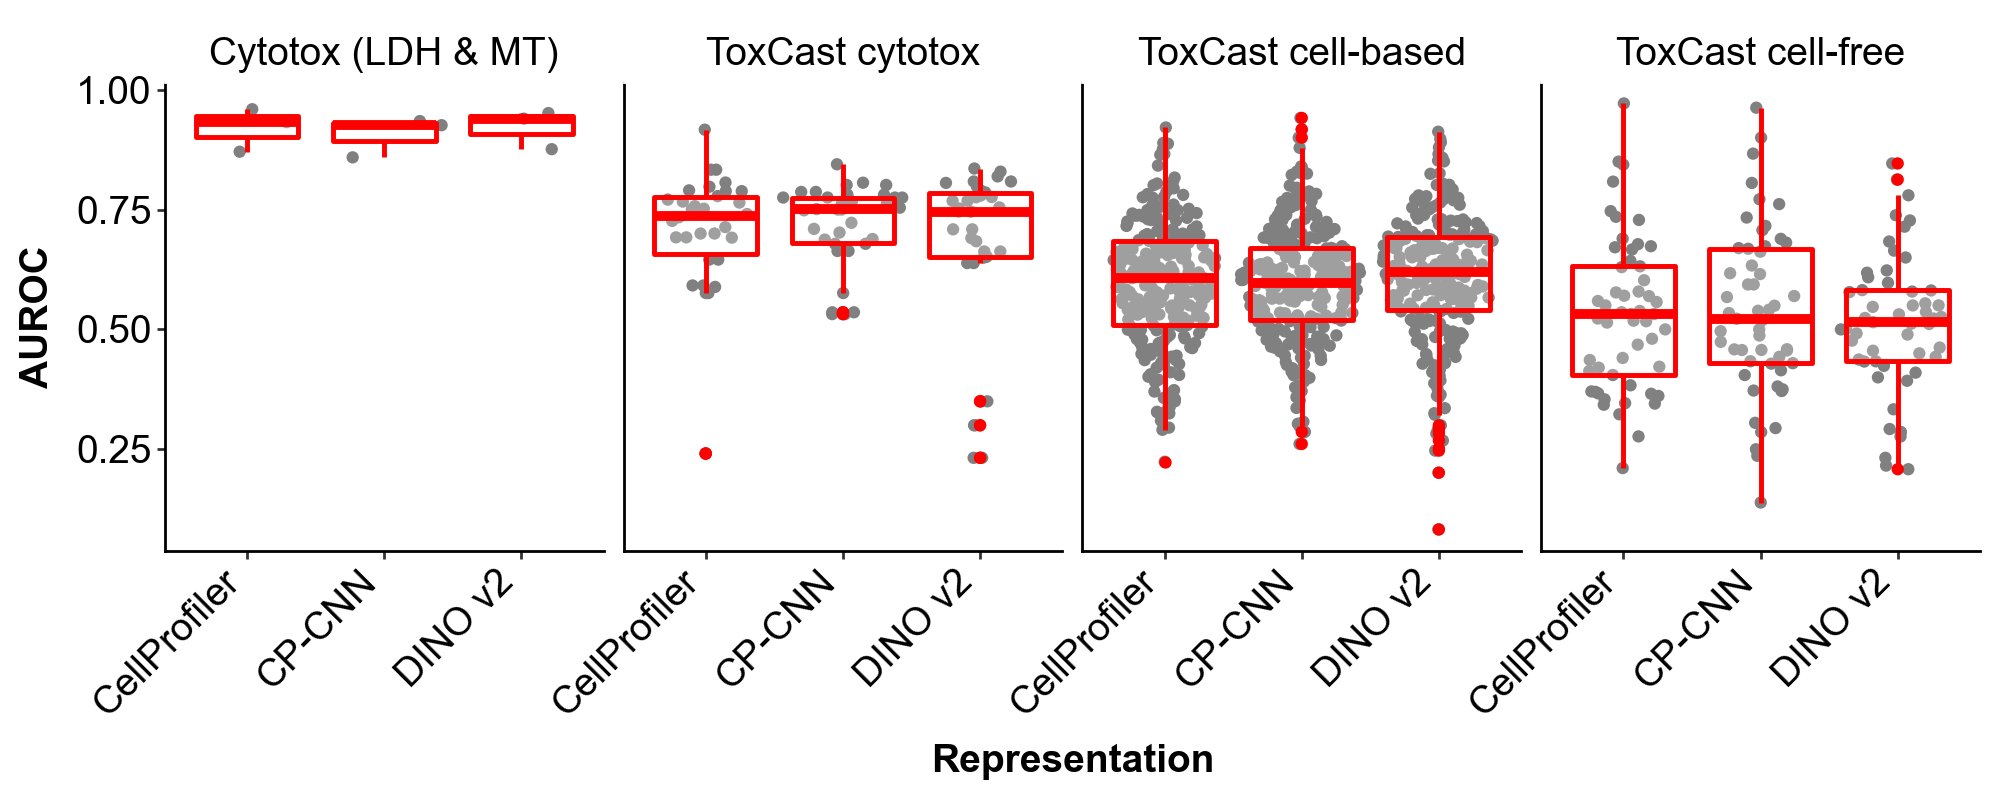

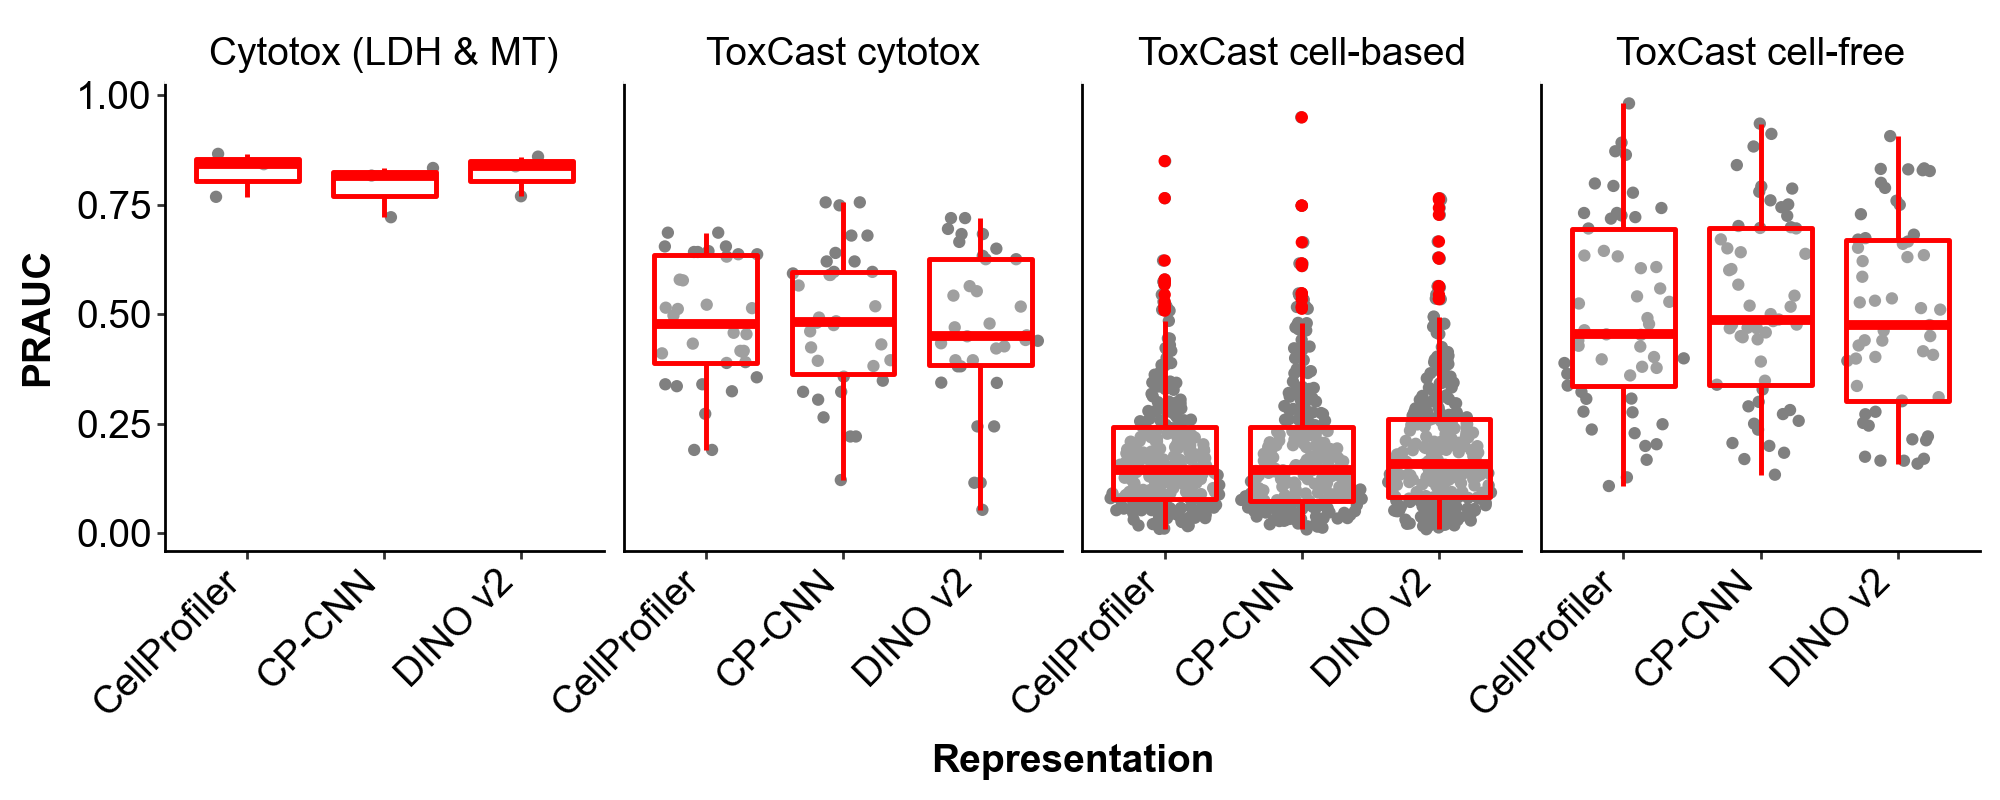

In [9]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_classic, position_dodge, facet_wrap, theme, element_text, scale_x_discrete, element_rect
import plotnine as pn

pn.options.figure_size = (10, 4)

custom_labels = {
    "axiom_cytotox": "Cytotox (LDH & MT)",
    "toxcast_cytotox": "ToxCast cytotox",
    "toxcast_cellbased": "ToxCast cell-based",
    "toxcast_cellfree": "ToxCast cell-free",
}
def label_func(label_dict):
    return lambda x: label_dict.get(x, x)

plot = (
    ggplot(pred_pandas, aes(x='Feat_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Endpoint_type", ncol=4, labeller=label_func(custom_labels))
    + labs(x='Representation', y='AUROC') 
    + theme_classic()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1, color='black', size=14, family='Arial'),
        axis_text_y=element_text(color='black', size=14, family='Arial'),
        axis_title_x=element_text(size=14, color='black', weight='bold', family='Arial'),
        axis_title_y=element_text(size=14, color='black', weight='bold', family='Arial'),
        strip_text_x=element_text(size=14, color='black', family='Arial'),
        strip_background=element_rect(fill=None, color='white', size=None, linetype=None),
        )
    + scale_x_discrete(labels={
        "cellprofiler": "CellProfiler", 
        "dino": "DINO v2", 
        "cpcnn": "CP-CNN"
    })
)
plot.show()

plot = (
    ggplot(pred_pandas, aes(x='Feat_type', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Endpoint_type", ncol=4, labeller=label_func(custom_labels))
    + labs(x='Representation', y='PRAUC') 
    + theme_classic()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1, color='black', size=14, family='Arial'),
        axis_text_y=element_text(color='black', size=14, family='Arial'),
        axis_title_x=element_text(size=14, color='black', weight='bold', family='Arial'),
        axis_title_y=element_text(size=14, color='black', weight='bold', family='Arial'),
        strip_text_x=element_text(size=14, color='black', family='Arial'),
        strip_background=element_rect(fill=None, color='white', size=None, linetype=None),
        )
    + scale_x_discrete(labels={
        "cellprofiler": "CellProfiler", 
        "dino": "DINO v2", 
        "cpcnn": "CP-CNN"
    })
)
plot.show()

In [11]:
warnings.filterwarnings("ignore")

auroc_results = {}

for endpoint_type, group_data in pred_pandas.groupby("Endpoint_type"):
    print(f"Processing Endpoint_type: {endpoint_type}")
    
    # Fit the mixed-effects model
    model = smf.mixedlm(
        "AUROC ~ Feat_type", 
        group_data, 
        groups=group_data["Metadata_Label"]
    )
    result = model.fit()
    
    # Add fitted values to the subset DataFrame
    group_data["fitted_values"] = result.fittedvalues

    # Perform Tukey's HSD
    mc = MultiComparison(group_data["fitted_values"], group_data["Feat_type"])
    tukey_result = mc.tukeyhsd()
    tukey_pvals = tukey_result.pvalues
    
    # Print results for the current Endpoint_type
    print(tukey_result.summary())
    print("P-values:", tukey_pvals)
    
    # Save results for each Endpoint_type in a dictionary for later reference
    auroc_results[endpoint_type] = {
        "tukey_summary": tukey_result.summary(),
        "tukey_pvalues": tukey_pvals,
        "fitted_model": result
    }

Processing Endpoint_type: axiom_cytotox
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
   group1    group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------------
cellprofiler  cpcnn  -0.0143 0.9101 -0.1198 0.0911  False
cellprofiler   dino   0.0015  0.999  -0.104 0.1069  False
       cpcnn   dino   0.0158 0.8922 -0.0897 0.1212  False
---------------------------------------------------------
P-values: [0.91005955 0.99900762 0.89223604]
Processing Endpoint_type: toxcast_cytotox
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1    group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------------
cellprofiler  cpcnn   0.0211 0.6203 -0.0327  0.0749  False
cellprofiler   dino  -0.0328 0.3189 -0.0866   0.021  False
       cpcnn   dino  -0.0539 0.0493 -0.1078 -0.0001   True
----------------------------------------------------------
P-values: [0.62026565 0.31893152 0.04932887]
Processin

In [12]:
warnings.filterwarnings("ignore")

auroc_results = {}

for endpoint_type, group_data in pred_pandas.groupby("Endpoint_type"):
    print(f"Processing Endpoint_type: {endpoint_type}")
    
    # Fit the mixed-effects model
    model = smf.mixedlm(
        "PRAUC ~ Feat_type", 
        group_data, 
        groups=group_data["Metadata_Label"]
    )
    result = model.fit()
    
    # Add fitted values to the subset DataFrame
    group_data["fitted_values"] = result.fittedvalues

    # Perform Tukey's HSD
    mc = MultiComparison(group_data["fitted_values"], group_data["Feat_type"])
    tukey_result = mc.tukeyhsd()
    tukey_pvals = tukey_result.pvalues
    
    # Print results for the current Endpoint_type
    print(tukey_result.summary())
    print("P-values:", tukey_pvals)
    
    # Save results for each Endpoint_type in a dictionary for later reference
    auroc_results[endpoint_type] = {
        "tukey_summary": tukey_result.summary(),
        "tukey_pvalues": tukey_pvals,
        "fitted_model": result
    }

Processing Endpoint_type: axiom_cytotox
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
   group1    group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------------
cellprofiler  cpcnn   -0.035 0.6928 -0.1625 0.0925  False
cellprofiler   dino  -0.0033 0.9965 -0.1308 0.1242  False
       cpcnn   dino   0.0317 0.7377 -0.0958 0.1592  False
---------------------------------------------------------
P-values: [0.69284855 0.99652055 0.73770324]
Processing Endpoint_type: toxcast_cytotox
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
   group1    group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------------
cellprofiler  cpcnn   0.0026  0.996 -0.0715 0.0768  False
cellprofiler   dino  -0.0136    0.9 -0.0878 0.0605  False
       cpcnn   dino  -0.0163 0.8606 -0.0904 0.0579  False
---------------------------------------------------------
P-values: [0.99602645 0.90001781 0.86057683]
Processing Endpo

### Concentrations (cell count baseline)

In [20]:
endpoint_types = ["toxcast_cellbased", "toxcast_cellfree", "toxcast_cytotox", "axiom"]

pred_df = []
for et in endpoint_types:
    preds = pl.read_parquet(f"../compiled_results/compiled_{et}_metrics.parquet")
    preds = preds.with_columns(
        (pl.col("Metadata_Count_0") + pl.col("Metadata_Count_1")).alias("Total_Compounds"),
        pl.lit(et).alias("Endpoint_type")
    )
    pred_df.append(preds)

pred_df = pl.concat(pred_df, how="vertical")
pred_df = pred_df.with_columns(
    pl.when(pl.col("Endpoint_type") == "axiom").then(pl.lit("axiom_cytotox")).otherwise(pl.col("Endpoint_type")).alias("Endpoint_type")
)

pred_df = pred_df.filter(pl.col("Model_type") == "Cellcount_baseline")

In [21]:
conc_df = pred_df.filter(pl.col("Feat_type") == "cellprofiler")

pred_pandas = conc_df.to_pandas()
pred_pandas['Endpoint_type'] = pd.Categorical(
    pred_pandas['Endpoint_type'], 
    categories=["axiom_cytotox", "toxcast_cytotox", "toxcast_cellbased", "toxcast_cellfree"],
    ordered=True
)

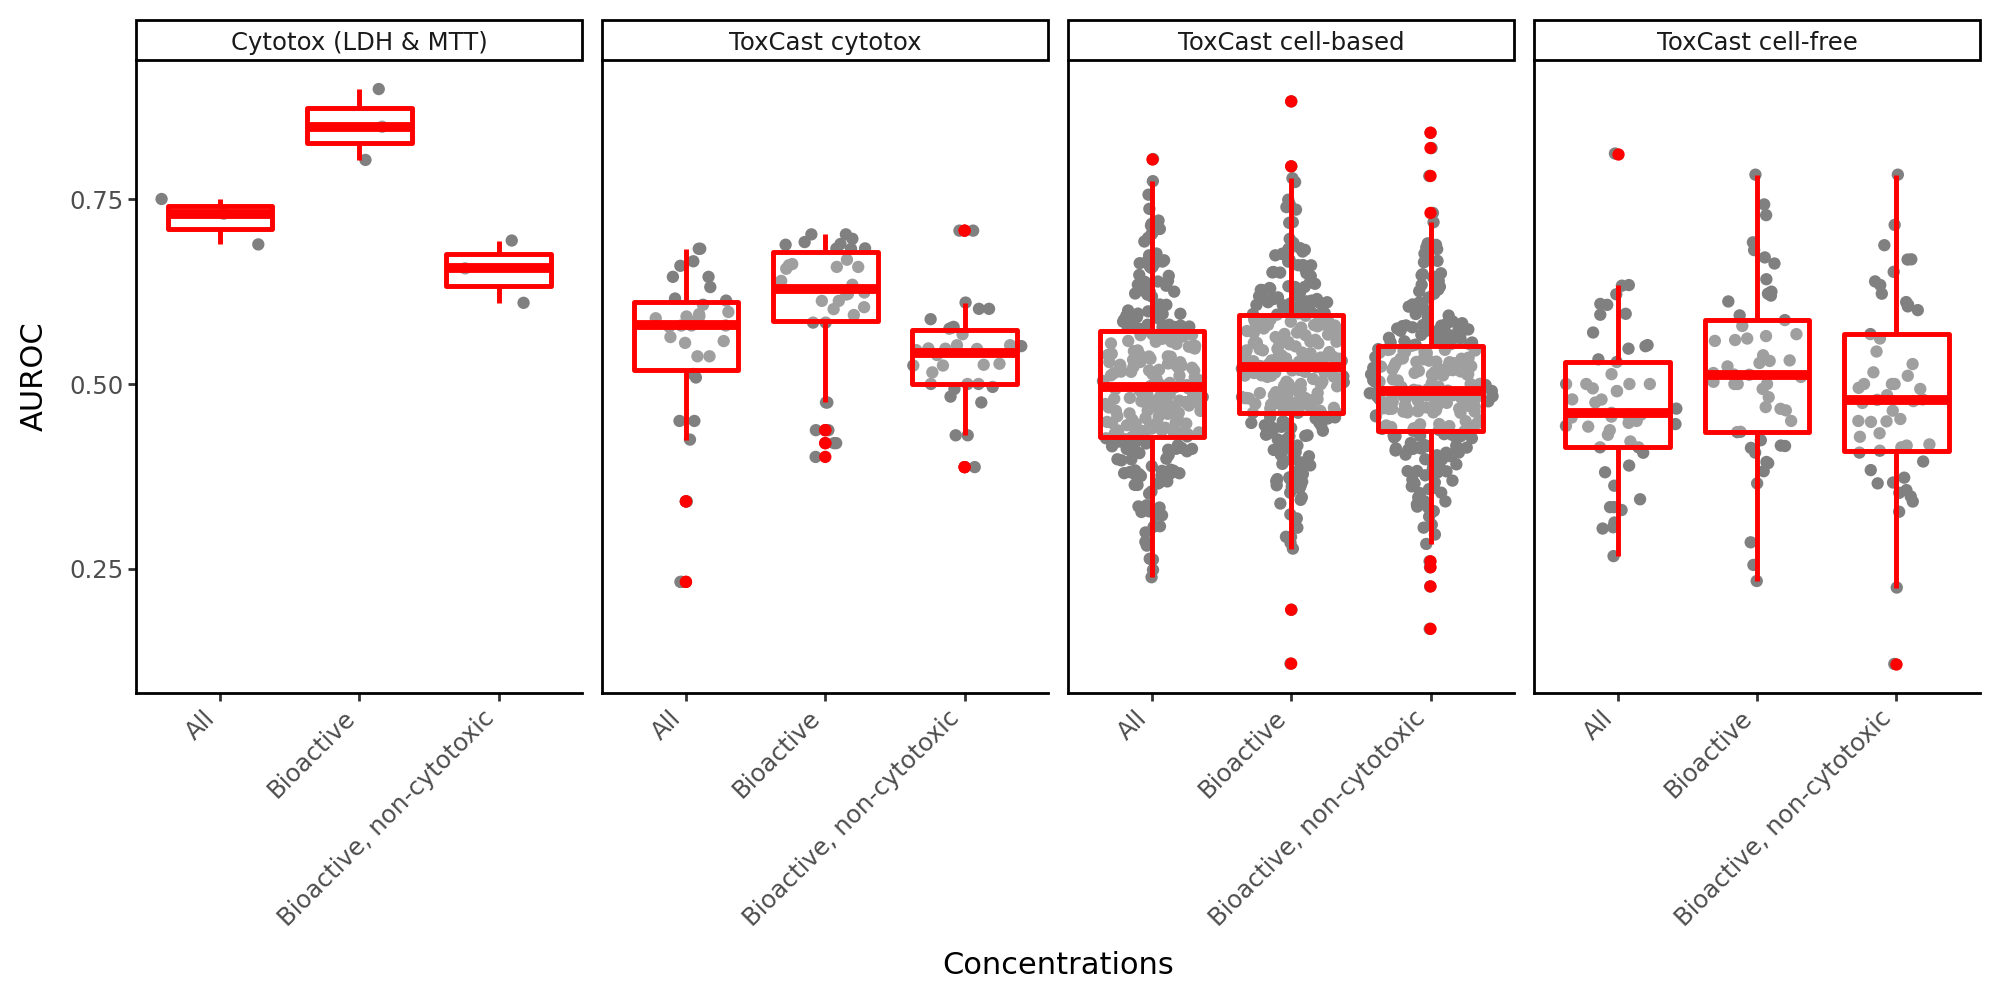

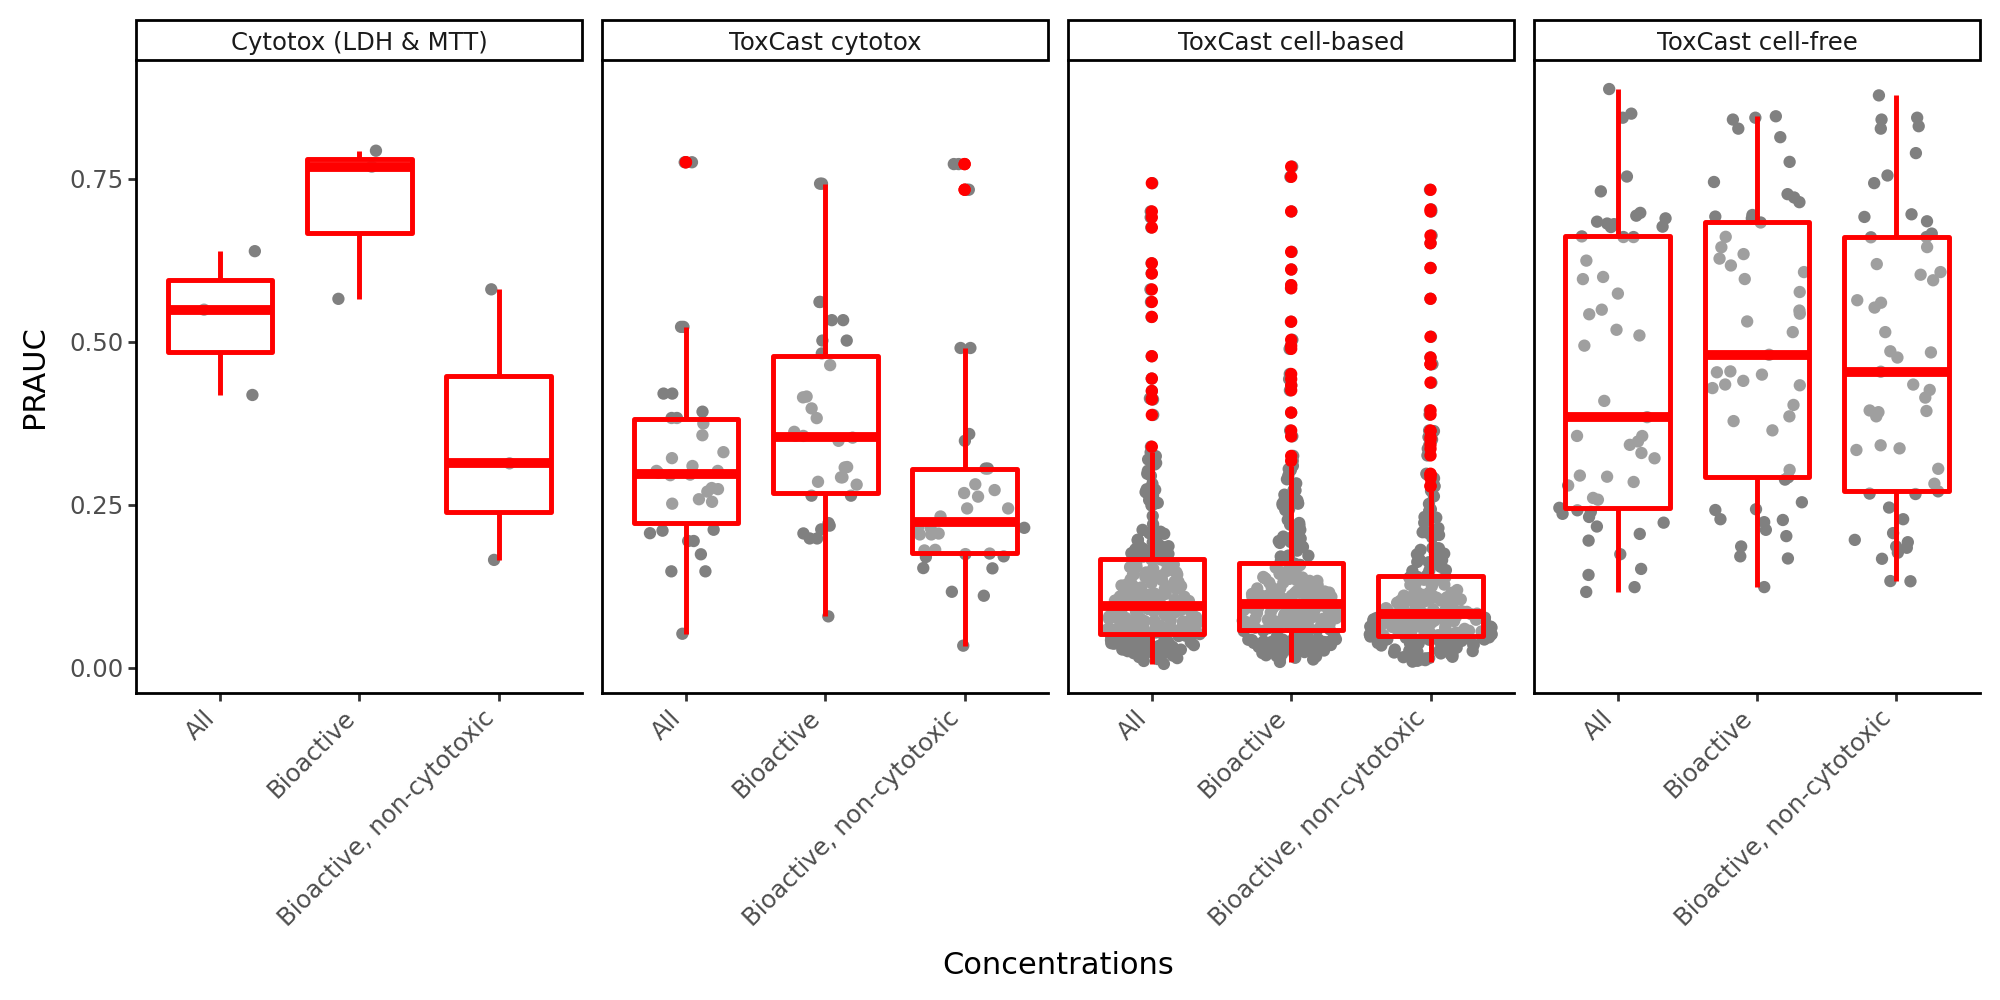

In [22]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_classic, position_dodge, facet_wrap, theme, element_text, scale_x_discrete
import plotnine as pn

pn.options.figure_size = (10, 5)

custom_labels = {
    "axiom_cytotox": "Cytotox (LDH & MTT)",
    "toxcast_cytotox": "ToxCast cytotox",
    "toxcast_cellbased": "ToxCast cell-based",
    "toxcast_cellfree": "ToxCast cell-free",
}
def label_func(label_dict):
    return lambda x: label_dict.get(x, x)

plot = (
    ggplot(pred_pandas, aes(x='Metadata_AggType', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Endpoint_type", ncol=4, labeller=label_func(custom_labels))
    + labs(x='Concentrations', y='AUROC') 
    + theme_classic()
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + scale_x_discrete(labels={
        "all": "All", 
        "allpod": "Bioactive", 
        "allpodcc": "Bioactive, non-cytotoxic"
    })
)
plot.show()

plot = (
    ggplot(pred_pandas, aes(x='Metadata_AggType', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Endpoint_type", ncol=4, labeller=label_func(custom_labels))
    + labs(x='Concentrations', y='PRAUC') 
    + theme_classic()
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + scale_x_discrete(labels={
        "all": "All", 
        "allpod": "Bioactive", 
        "allpodcc": "Bioactive, non-cytotoxic"
    })
)
plot.show()

In [23]:
warnings.filterwarnings("ignore")

auroc_results = {}

for endpoint_type, group_data in pred_pandas.groupby("Endpoint_type"):
    print(f"Processing Endpoint_type: {endpoint_type}")
    
    # Fit the mixed-effects model
    model = smf.mixedlm(
        "AUROC ~ Metadata_AggType", 
        group_data, 
        groups=group_data["Metadata_Label"]
    )
    result = model.fit()
    
    # Add fitted values to the subset DataFrame
    group_data["fitted_values"] = result.fittedvalues

    # Perform Tukey's HSD
    mc = MultiComparison(group_data["fitted_values"], group_data["Metadata_AggType"])
    tukey_result = mc.tukeyhsd()
    tukey_pvals = tukey_result.pvalues
    
    # Print results for the current Endpoint_type
    print(tukey_result.summary())
    print("P-values:", tukey_pvals)
    
    # Save results for each Endpoint_type in a dictionary for later reference
    auroc_results[endpoint_type] = {
        "tukey_summary": tukey_result.summary(),
        "tukey_pvalues": tukey_pvals,
        "fitted_model": result
    }

Processing Endpoint_type: axiom_cytotox
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
   all   allpod    0.127   0.0  0.1224  0.1316   True
   all allpodcc  -0.0697   0.0 -0.0743 -0.0651   True
allpod allpodcc  -0.1967   0.0 -0.2013 -0.1921   True
-----------------------------------------------------
P-values: [4.47852200e-10 1.62578858e-08 3.60325103e-11]
Processing Endpoint_type: toxcast_cytotox
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
   all   allpod   0.0594 0.0038  0.0166  0.1023   True
   all allpodcc  -0.0107 0.8249 -0.0535  0.0322  False
allpod allpodcc  -0.0701 0.0005 -0.1129 -0.0273   True
------------------------------------------------------
P-values: [3.79979325e-03 8.24863446e-01 5.23703075e-04]
Processing Endpoint_type: toxcast_cellbas

In [24]:
warnings.filterwarnings("ignore")

auroc_results = {}

for endpoint_type, group_data in pred_pandas.groupby("Endpoint_type"):
    print(f"Processing Endpoint_type: {endpoint_type}")
    
    # Fit the mixed-effects model
    model = smf.mixedlm(
        "PRAUC ~ Metadata_AggType", 
        group_data, 
        groups=group_data["Metadata_Label"]
    )
    result = model.fit()
    
    # Add fitted values to the subset DataFrame
    group_data["fitted_values"] = result.fittedvalues

    # Perform Tukey's HSD
    mc = MultiComparison(group_data["fitted_values"], group_data["Metadata_AggType"])
    tukey_result = mc.tukeyhsd()
    tukey_pvals = tukey_result.pvalues
    
    # Print results for the current Endpoint_type
    print(tukey_result.summary())
    print("P-values:", tukey_pvals)
    
    # Save results for each Endpoint_type in a dictionary for later reference
    auroc_results[endpoint_type] = {
        "tukey_summary": tukey_result.summary(),
        "tukey_pvalues": tukey_pvals,
        "fitted_model": result
    }

Processing Endpoint_type: axiom_cytotox
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
   all   allpod   0.1736 0.2828 -0.1412  0.4884  False
   all allpodcc  -0.1824 0.2547 -0.4972  0.1324  False
allpod allpodcc   -0.356 0.0308 -0.6707 -0.0412   True
------------------------------------------------------
P-values: [0.28281043 0.25465836 0.03078078]
Processing Endpoint_type: toxcast_cytotox
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
   all   allpod   0.0508 0.2677 -0.0267  0.1284  False
   all allpodcc  -0.0269 0.6879 -0.1044  0.0506  False
allpod allpodcc  -0.0778 0.0492 -0.1553 -0.0002   True
------------------------------------------------------
P-values: [0.26765278 0.68789628 0.04917708]
Processing Endpoint_type: toxcast_cellbased
 Multiple Comp